<a href="https://colab.research.google.com/github/gracekazmierski/machinelearning/blob/main/knee_osteoporosis_vgg19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout
from keras.applications.vgg19 import VGG19
from keras.models import Model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip -q "/content/drive/My Drive/knee-xray/Knee Osteoporosis Dataset multiclasses.zip" -d "multiclasses_dataset" && echo "unzipped Knee Osteoporosis Dataset multiclasses.zip"
!unzip -q "/content/drive/My Drive/knee-xray/Osteoporosis Knee Dataset (Preprocessed-128x256).zip" -d "preprocessed_dataset" && echo "unzipped Osteoporosis Knee Dataset (Preprocessed-128x256).zip"
!unzip -q "/content/drive/My Drive/knee-xray/Osteoporosis Knee X-ray Dataset.zip" -d "xray_dataset" && echo "unzipped Osteoporosis Knee X-ray Dataset.zip"
!unzip -q "/content/drive/My Drive/knee-xray/Osteoporosis.zip" -d "osteoporosis_dataset" && echo "unzipped Osteoporosis.zip"

unzipped Knee Osteoporosis Dataset multiclasses.zip
unzipped Osteoporosis Knee Dataset (Preprocessed-128x256).zip
unzipped Osteoporosis Knee X-ray Dataset.zip
unzipped Osteoporosis.zip


In [4]:
healthy_dirs = [
    r'/content/multiclasses_dataset/Osteoporosis Knee X-ray/normal',
    r'/content/osteoporosis_dataset/osteoporosis/normal',
    r'/content/preprocessed_dataset/Osteoporosis Knee Dataset/Normal',
    r'/content/xray_dataset/normal/normal'
]

osteoporosis_dirs = [
    r'/content/multiclasses_dataset/Osteoporosis Knee X-ray/osteoporosis',
    r'/content/osteoporosis_dataset/osteoporosis/osteoporosis',
    r'/content/preprocessed_dataset/Osteoporosis Knee Dataset/Osteoporosis',
    r'/content/xray_dataset/osteoporosis/osteoporosis'
]

In [5]:
filepaths = []
labels = []
dict_lists = [healthy_dirs, osteoporosis_dirs]
class_labels = ['Healthy', 'Osteoporosis']

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        if os.path.exists(j):
            flist = os.listdir(j)
            for f in flist:
                fpath = os.path.join(j, f)
                filepaths.append(fpath)
                labels.append(class_labels[i])
        else:
            print(f"Directory not found: {j}")

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
df = pd.concat([Fseries, Lseries], axis=1)

print(df.head())
print(df["labels"].value_counts())

                                           filepaths   labels
0  /content/multiclasses_dataset/Osteoporosis Kne...  Healthy
1  /content/multiclasses_dataset/Osteoporosis Kne...  Healthy
2  /content/multiclasses_dataset/Osteoporosis Kne...  Healthy
3  /content/multiclasses_dataset/Osteoporosis Kne...  Healthy
4  /content/multiclasses_dataset/Osteoporosis Kne...  Healthy
labels
Osteoporosis    793
Healthy         780
Name: count, dtype: int64


In [6]:
df.shape

(1573, 2)

In [7]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['labels'])
train_set, val_set = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['labels'])

In [8]:
print(train_set.shape)
print(test_df.shape)
print(val_set.shape)
print(train_df.shape)

(880, 2)
(472, 2)
(221, 2)
(1101, 2)


In [9]:
from tensorflow.keras.applications.vgg19 import preprocess_input

image_gen_train = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

image_gen_val_test = ImageDataGenerator(preprocessing_function=preprocess_input)

image_size = (224, 224)

train = image_gen_train.flow_from_dataframe(
    dataframe=train_set,
    x_col="filepaths",
    y_col="labels",
    target_size=image_size,
    color_mode='rgb',
    class_mode="binary",
    batch_size=4,
    shuffle=True
)

val = image_gen_val_test.flow_from_dataframe(
    dataframe=val_set,
    x_col="filepaths",
    y_col="labels",
    target_size=image_size,
    color_mode='rgb',
    class_mode="binary",
    batch_size=4,
    shuffle=False
)

test = image_gen_val_test.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepaths",
    y_col="labels",
    target_size=image_size,
    color_mode='rgb',
    class_mode="binary",
    batch_size=4,
    shuffle=False
)

Found 880 validated image filenames belonging to 2 classes.
Found 221 validated image filenames belonging to 2 classes.
Found 472 validated image filenames belonging to 2 classes.


In [10]:
print(train.class_indices)

{'Healthy': 0, 'Osteoporosis': 1}


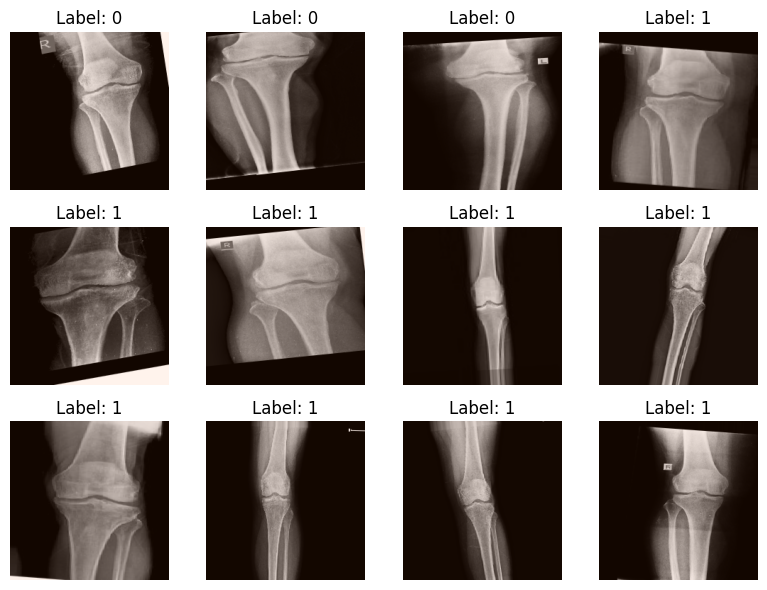

In [11]:
def plot_image_grid(generator, grid_size=(3, 4)):
    total_images = grid_size[0] * grid_size[1]
    imgs = []
    labs = []

    while len(imgs) < total_images:
        batch_imgs, batch_labs = next(generator)
        imgs.extend(batch_imgs)
        labs.extend(batch_labs)

    imgs = imgs[:total_images]
    labs = labs[:total_images]

    imgs_array = np.array(imgs)
    imgs_scaled = imgs_array + abs(np.min(imgs_array))
    imgs_scaled = imgs_scaled / np.max(imgs_scaled)


    plt.figure(figsize=(grid_size[1] * 2, grid_size[0] * 2))
    for i in range(total_images):
        plt.subplot(grid_size[0], grid_size[1], i + 1)
        # Plot the scaled image from the new array
        plt.imshow(imgs_scaled[i])
        plt.title(f"Label: {int(labs[i])}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_image_grid(train)

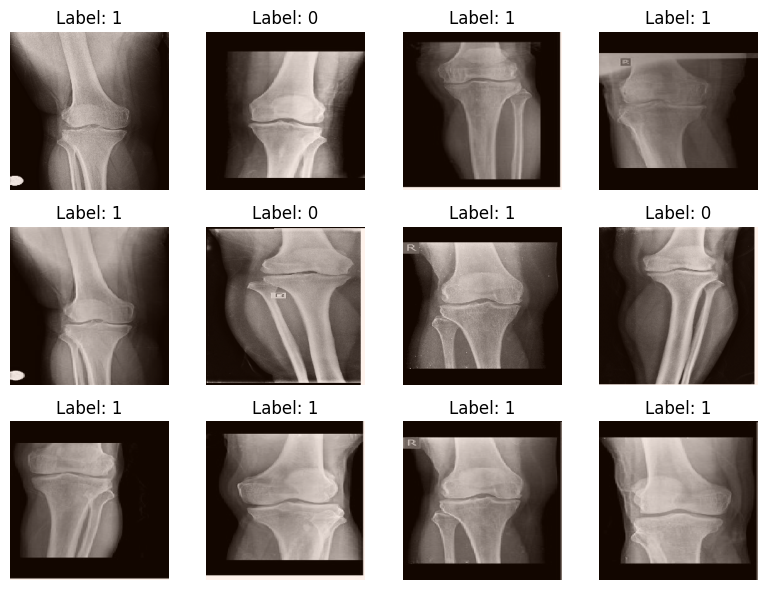

In [12]:
def plot_image_grid(generator, grid_size=(3, 4)):
    total_images = grid_size[0] * grid_size[1]
    imgs = []
    labs = []

    while len(imgs) < total_images:
        batch_imgs, batch_labs = next(generator)
        imgs.extend(batch_imgs)
        labs.extend(batch_labs)

    imgs = imgs[:total_images]
    labs = labs[:total_images]

    imgs_array = np.array(imgs)
    imgs_scaled = imgs_array + abs(np.min(imgs_array))
    imgs_scaled = imgs_scaled / np.max(imgs_scaled)


    plt.figure(figsize=(grid_size[1] * 2, grid_size[0] * 2))
    for i in range(total_images):
        plt.subplot(grid_size[0], grid_size[1], i + 1)
        plt.imshow(imgs_scaled[i])
        plt.title(f"Label: {int(labs[i])}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_image_grid(test)

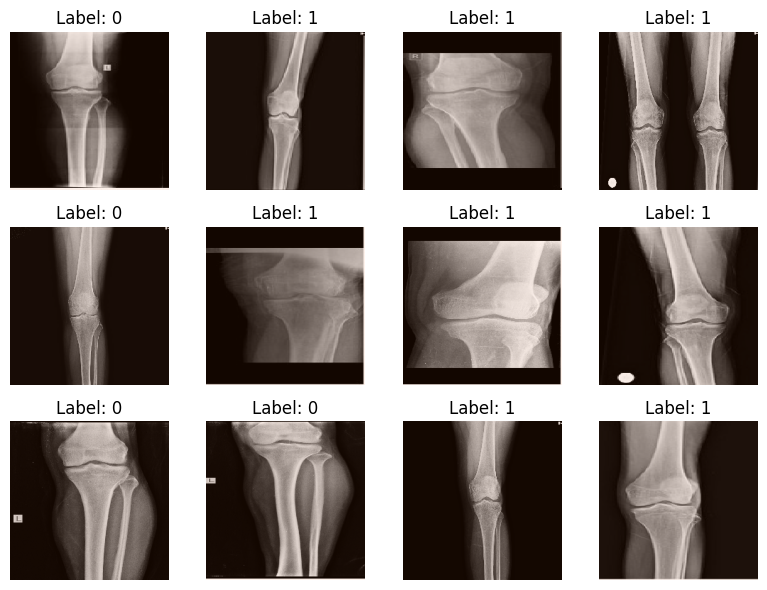

In [13]:
def plot_image_grid(generator, grid_size=(3, 4)):
    total_images = grid_size[0] * grid_size[1]
    imgs = []
    labs = []

    while len(imgs) < total_images:
        batch_imgs, batch_labs = next(generator)
        imgs.extend(batch_imgs)
        labs.extend(batch_labs)

    imgs = imgs[:total_images]
    labs = labs[:total_images]

    imgs_array = np.array(imgs)
    imgs_scaled = imgs_array + abs(np.min(imgs_array))
    imgs_scaled = imgs_scaled / np.max(imgs_scaled)


    plt.figure(figsize=(grid_size[1] * 2, grid_size[0] * 2))
    for i in range(total_images):
        plt.subplot(grid_size[0], grid_size[1], i + 1)
        plt.imshow(imgs_scaled[i])
        plt.title(f"Label: {int(labs[i])}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_image_grid(val)

In [14]:
vgg19_weights = '/kaggle/input/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels.h5'
vgg19_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = vgg19_model.output

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [15]:
vgg19_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

vgg19_model.trainable = False

x = vgg19_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=vgg19_model.input, outputs=output)

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,155,969 (76.89 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [16]:
print(f"Model input shape: {model.input_shape}")
print(f"Model output shape: {model.output_shape}")

images, labels = next(train)
print(f"Batch image shape: {images.shape}")
print(f"Batch labels shape: {labels.shape}")
print(f"Sample labels:\n{labels[:5]}")

Model input shape: (None, 224, 224, 3)
Model output shape: (None, 1)
Batch image shape: (4, 224, 224, 3)
Batch labels shape: (4,)
Sample labels:
[0. 0. 1. 0.]


In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    verbose=1,
    mode='min',
    min_lr=1e-6
)

In [26]:
checkpoint = ModelCheckpoint(
    'knee_osteoporosis.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

callbacks_list = [checkpoint, early_stopping, reduce_lr]

history = model.fit(
    train,
    epochs=100,
    validation_data=val,
    callbacks=callbacks_list
)

Epoch 1/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.5977 - loss: 0.8605
Epoch 1: val_loss improved from inf to 0.53936, saving model to knee_osteoporosis.keras
220/220 ━━━━━━━━━━━━━━━━━━━━ 37s 166ms/step - accuracy: 0.5979 - loss: 0.8597 - val_accuracy: 0.7511 - val_loss: 0.5394 - learning_rate: 1.0000e-05
Epoch 2/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.7474 - loss: 0.5145
Epoch 2: val_loss improved from 0.53936 to 0.52879, saving model to knee_osteoporosis.keras
220/220 ━━━━━━━━━━━━━━━━━━━━ 31s 142ms/step - accuracy: 0.7474 - loss: 0.5144 - val_accuracy: 0.7149 - val_loss: 0.5288 - learning_rate: 1.0000e-05
Epoch 3/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.7464 - loss: 0.5314
Epoch 3: val_loss improved from 0.52879 to 0.50479, saving model to knee_osteoporosis.keras
220/220 ━━━━━━━━━━━━━━━━━━━━ 33s 147ms/step - accuracy: 0.7465 - loss: 0.5313 - val_accuracy: 0.7647 - val_loss: 0.5048 - learning_rate: 1.0000e-05
Epoch 4/100
220/2

In [27]:
vgg19_model.trainable = True

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.optimizers.Adam(learning_rate=1e-5),
    metrics=['accuracy']
)


history_fine_tune = model.fit(
    train,
    epochs=20,
    validation_data=val,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

Epoch 1/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9459 - loss: 0.1456
Epoch 1: val_loss did not improve from 0.29444
220/220 ━━━━━━━━━━━━━━━━━━━━ 41s 146ms/step - accuracy: 0.9458 - loss: 0.1458 - val_accuracy: 0.8869 - val_loss: 0.3784 - learning_rate: 1.0000e-05
Epoch 2/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9516 - loss: 0.1388
Epoch 2: val_loss improved from 0.29444 to 0.29435, saving model to knee_osteoporosis.keras
220/220 ━━━━━━━━━━━━━━━━━━━━ 33s 148ms/step - accuracy: 0.9515 - loss: 0.1388 - val_accuracy: 0.9186 - val_loss: 0.2943 - learning_rate: 1.0000e-05
Epoch 3/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9274 - loss: 0.1661
Epoch 3: val_loss did not improve from 0.29435
220/220 ━━━━━━━━━━━━━━━━━━━━ 40s 144ms/step - accuracy: 0.9274 - loss: 0.1660 - val_accuracy: 0.9095 - val_loss: 0.3096 - learning_rate: 1.0000e-05
Epoch 4/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9493 - loss: 0.1244
Epoch 4: val_loss 

In [33]:
history_fine_tune_two = model.fit(
    train,
    epochs=30,
    validation_data=val,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

Epoch 1/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9584 - loss: 0.0742
Epoch 1: val_loss did not improve from 0.29435
220/220 ━━━━━━━━━━━━━━━━━━━━ 31s 140ms/step - accuracy: 0.9584 - loss: 0.0742 - val_accuracy: 0.9140 - val_loss: 0.4473 - learning_rate: 1.0000e-06
Epoch 2/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9556 - loss: 0.0942
Epoch 2: val_loss did not improve from 0.29435
220/220 ━━━━━━━━━━━━━━━━━━━━ 31s 142ms/step - accuracy: 0.9556 - loss: 0.0942 - val_accuracy: 0.9140 - val_loss: 0.4091 - learning_rate: 1.0000e-06
Epoch 3/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9726 - loss: 0.0786
Epoch 3: val_loss did not improve from 0.29435
220/220 ━━━━━━━━━━━━━━━━━━━━ 33s 149ms/step - accuracy: 0.9726 - loss: 0.0786 - val_accuracy: 0.9140 - val_loss: 0.4460 - learning_rate: 1.0000e-06
Epoch 4/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9559 - loss: 0.0826
Epoch 4: val_loss did not improve from 0.29435
220/220 ━━━━━━━━

In [34]:
model.save('osteoporosis_model_v2.keras')

In [35]:
# from tensorflow.keras.models import load_model

# # Load the best model saved during training
# model = load_model('osteoporosis_model_v1.keras')
# print("osteoporosis_model_v1.keras loaded as model")

In [36]:
raw = model.predict(test)
predicted_labels = (raw > 0.5).astype(int)

print(predicted_labels[:10].flatten())

118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step
[1 0 0 1 1 0 1 0 1 1]



Classification Report:
              precision    recall  f1-score   support

     Healthy       0.92      0.93      0.92       234
Osteoporosis       0.93      0.92      0.92       238

    accuracy                           0.92       472
   macro avg       0.92      0.92      0.92       472
weighted avg       0.92      0.92      0.92       472


Confusion Matrix:


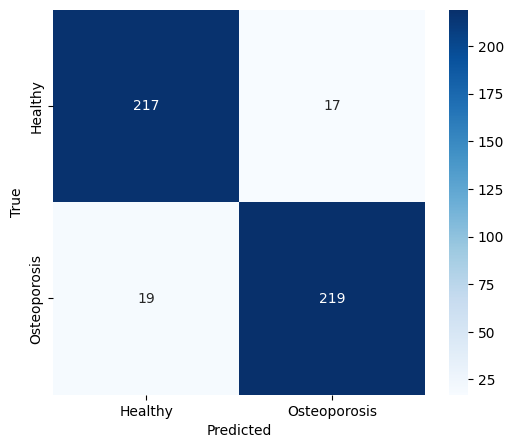

In [37]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def plot_results():
  true_labels = test.classes

  print("\nClassification Report:")
  print(classification_report(true_labels, predicted_labels, target_names=['Healthy', 'Osteoporosis']))

  print("\nConfusion Matrix:")
  cm = confusion_matrix(true_labels, predicted_labels)
  plt.figure(figsize=(6, 5))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Osteoporosis'], yticklabels=['Healthy', 'Osteoporosis'])
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()

plot_results()

In [43]:
print(test_df['filepaths'].iloc[1])

/content/osteoporosis_dataset/osteoporosis/normal/Normal_95.jpg


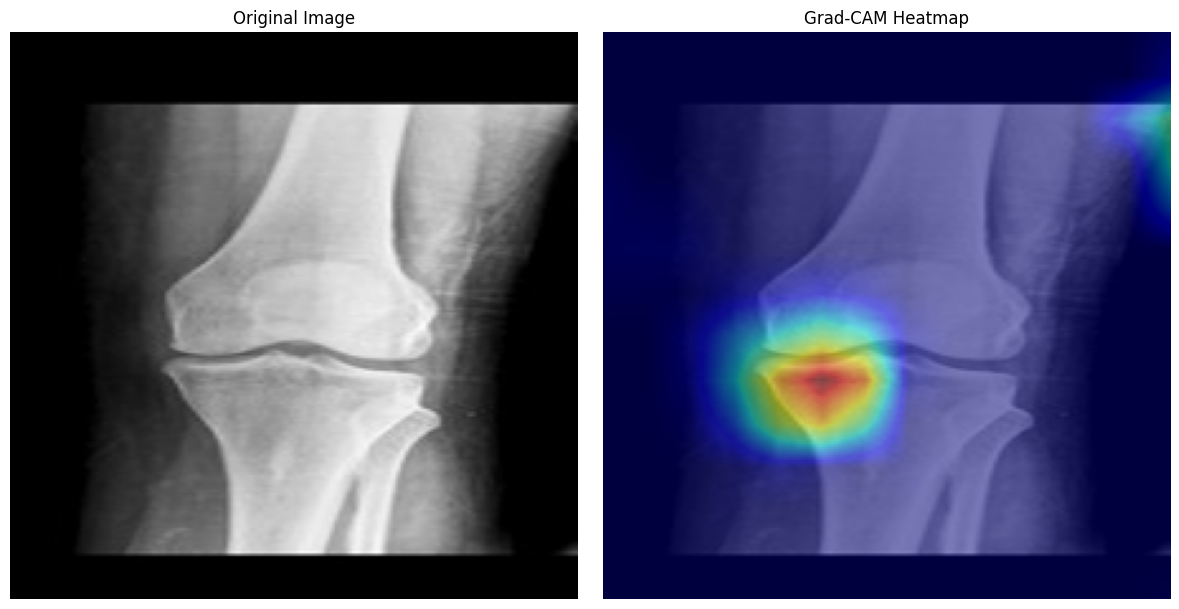

In [44]:
from PIL import Image
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.scores import BinaryScore

image_path = '/content/osteoporosis_dataset/osteoporosis/normal/Normal_95.jpg'
img = Image.open(image_path).convert('RGB').resize((224, 224))
image_array = np.array(img)
preprocessed_image = tf.keras.applications.vgg19.preprocess_input(image_array)

image_batch = np.expand_dims(preprocessed_image, axis=0)

def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m

gradcam = Gradcam(model,
                  model_modifier=model_modifier,
                  clone=True)

score = BinaryScore(1)
cam = gradcam(score,
              image_batch,
              penultimate_layer=-1)

heatmap = np.uint8(plt.cm.jet(cam[0])[..., :3] * 255)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Grad-CAM Heatmap")
plt.imshow(img)
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.axis('off')

plt.tight_layout()
plt.show()